In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

In [2]:
def replace_nan(df):
    # get a list of all the columns containing NaN
    nan_cols = df[df.columns[df.isnull().any()]].columns
    nan_cols = nan_cols.drop('bikes')
    # compute and fill each NaN with the columns mean
    df[nan_cols] = df[nan_cols].fillna(value=df[nan_cols].mean())

    
def show_nans(df):
    print(np.unique(df['station']))
    print(df.shape[0] - df.dropna().shape[0])
#     print(df[df.columns[df.isnull().any()]].columns)
    print(df.isnull().any())
    print()
    

# converting weekdays into integers [1-7]
def convert_weekdays(df):
    df = df.replace(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    [1, 2, 3, 4, 5, 6, 7])
    return df
    
def score_abs_error(model, data, num_docks, round_ = False):
    if round_ == True:
        y_pred = np.around(  model.predict(data.iloc[:,:-1].to_numpy()))# * num_docks  )
    else:
        y_pred = model.predict(data.iloc[:,:-1].to_numpy())# * num_docks
    y_gold = data["bikes"].to_numpy()# * num_docks
    
    return mean_absolute_error(y_gold, y_pred)

def reasonable_predictions(model, data):
    y_pred = model.predict(data.to_numpy())
    
    y_pred = np.around(y_pred)
    return y_pred


## This code is added

In [3]:
pd.options.mode.chained_assignment = None

def is_hol_weekend(row):
    if row['weekday'] == 6 or row['weekday'] == 7:
        return 1
    if row['isHoliday'] == 1:
        return 1
    if row['hour'] > 17 or row['hour'] < 9:
        return 1
    return 0

def generate_dataframe(dataframe):
    dataframe = convert_weekdays(dataframe)
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    # del df["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    default_columns = list(dataframe.columns)
    
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    default_columns = ["isOff"] + default_columns
    
    dataframe = dataframe[default_columns]
    
    print(dataframe.columns)
    
    del dataframe['isHoliday']
    #del dataframe["timestamp"]
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
#     print(columns)
#     for c in columns:
#         dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    del dataframe["numDocks"]
    
    return dataframe, num_docks

def vectorise_dataframe(dataframe):
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    #del dataframe["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    #del dataframe["weekhour"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    
    default_columns = list(dataframe.columns)
    #default_columns.remove('weekday')
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    #dataframe = pd.get_dummies(dataframe, columns=['weekday'])
    
    #default_columns = ["isOff", "weekday_Sunday", "weekday_Monday", "weekday_Tuesday", "weekday_Wednesday", 
                      #"weekday_Thursday", "weekday_Friday", "weekday_Saturday"] + default_columns
    
    default_columns = ["isOff"] + default_columns
    #del dataframe["weekday"]
    default_columns.remove('weekday')
    #print(default_columns)
    
    
    dataframe = dataframe[default_columns]
    
    #print(dataframe.columns)
    
    del dataframe['isHoliday']
    #del dataframe["timestamp"]
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
#     #print(columns)
#     for c in columns:
#         dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    dataframe["numDocks"]
    
    
    
    
#     columns_kept = ["weekday", "hour", "isOff",  'full_profile_3h_diff_bikes', 
#                      'short_profile_3h_diff_bikes',  "bikes"] #'bikes_3h_ago',
    
#     for c in dataframe.columns:
#         if c not in columns_kept:
#             del dataframe[c]
    
    
    return dataframe, num_docks

# Adding all files into one DataFrame
trains = []
vals = []

train_docks_list = []
val_docks_list = []

scalers = []

count = 0
for i, path in enumerate(Path('./Train/Train').rglob('*.csv')):
    count += 1

val_inds = list(np.random.randint(0, count - 1, 2))
print(val_inds)

for i, path in enumerate(Path('./Train/Train').rglob('*.csv')):
    tmp = pd.read_csv(path)

    tmp = tmp.dropna(axis='rows')

    if i  not in  val_inds:
        train, val = train_test_split(tmp, test_size=0.2)

        train, train_docks = vectorise_dataframe(train)
        val, val_docks = vectorise_dataframe(val)

        scaler = RobustScaler()
        
        train[train.columns[:-1]] = scaler.fit_transform(train[train.columns[:-1]])
        val[val.columns[:-1]] = scaler.transform(val[val.columns[:-1]])

        trains.append(train)
        vals.append(val)

        train_docks_list.append(train_docks)
        val_docks_list.append(val_docks)

        scalers.append(scaler)
        
        del tmp
        
    elif i == val_inds[0]:
        val_set = tmp.copy()


        val_set, val_set_docks = vectorise_dataframe(val_set)
    else:
        print('found val set two')
        val_set_two = tmp.copy()


        val_set_two, val_set_docks_two = vectorise_dataframe(val_set_two)


    
    

print(len(trains))

[55, 68]
found val set two
73


In [4]:
from time import time
from tqdm import tqdm
start = time()
print("initialised")

models = []

for i in tqdm(range(len(trains))):
    #forest_boost = AdaBoostRegressor(n_estimators=400, random_state=0, learning_rate = 0.5)
    forest_boost = RandomForestRegressor(n_estimators= 200, max_depth= 5)
    #forest_boost = GradientBoostingRegressor(n_estimators= 150, max_depth= 3, learning_rate= 0.1, loss="squared_error")#
    forest_boost.fit(trains[i].iloc[:,:-1].to_numpy(), trains[i]["bikes"].to_numpy())
    
    models.append(forest_boost)
print(f'fitted in {time() - start}s')

initialised


100%|████████████████████████████████████████████| 73/73 [00:18<00:00,  4.00it/s]

fitted in 18.257344961166382s


In [5]:
# Adding all files into one DataFrame

df = []
for i, path in enumerate(Path('./Train/Train').rglob('*.csv')):
    if i not in val_inds:
        tmp = pd.read_csv(path)
        tmp = tmp.dropna(axis='rows')
        df.append(tmp)

df = pd.concat(df, ignore_index=True)

train, val = train_test_split(df, test_size=0.2)

train, train_docks = vectorise_dataframe(train)
val, val_docks = vectorise_dataframe(val)

x = train.iloc[:,:-1].to_numpy()
y = train['bikes'].to_numpy()

In [6]:
from sklearn import linear_model

# Adding all files into one DataFrame
all_columns = list(train.columns)


for path in Path('./Models/Models').rglob('*.csv'):
    tmp = pd.read_csv(path)
    # comment next line if not averaging NaNs  
    # show_nans(tmp)
    #replace_nan(tmp)
    tmp = tmp.dropna(axis='rows')
    features = tmp['feature']
    weights = tmp['weight']
    
    weight_based = np.zeros((1, len(all_columns)))
    model_frame = pd.DataFrame(data=weight_based, columns=all_columns)
    
    for i, f in enumerate(features):
        model_frame[f] = weights[i]
    
    # removing intercept and bikes
    final_weights = model_frame.iloc[0,:-2].to_numpy()
    
    intercept = model_frame.iloc[0,-1]
    
    model = linear_model.LinearRegression()
    model.coef_ = final_weights
    model.intercept_ = intercept    
    
    models.append(model)
    
    trains.append(train)
    vals.append(val)
    
    train_docks_list.append(0)
    val_docks_list.append(0)

    
    scalers.append(None)


100%|████████████████████████████████████████| 1273/1273 [01:03<00:00, 19.95it/s]


Non-rounded ensemble error: 2.733694952296056


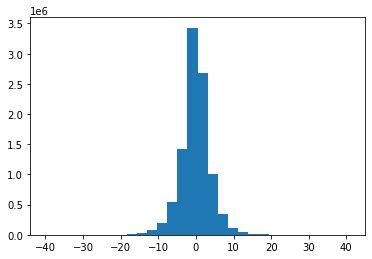

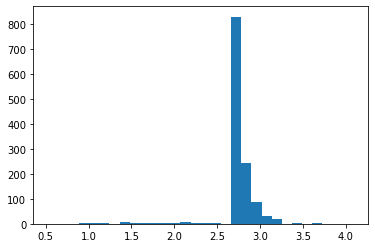

In [7]:
import matplotlib.pyplot as plt


errors = []
y_pred = []
y_gold = []

for i in tqdm(range(len(vals))):
    errors.append(score_abs_error(models[i], vals[i], val_docks_list[i]))
    
    pred = list(models[i].predict(vals[i].iloc[:, :-1].to_numpy()))# * val_docks_list[i])
    
    y_pred = y_pred + pred
    
    y_gold = y_gold + list(vals[i]["bikes"])# * val_docks_list[i])
    
print(f'Non-rounded ensemble error: {np.mean(errors)}')

plt.hist(np.array(y_pred) - np.array(y_gold), bins=30)
plt.show()
plt.hist(errors, bins=30)
plt.show()

1.0


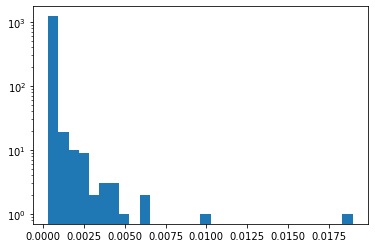

In [12]:
model_weights = np.array(errors)**(2)
model_weights = 1/ model_weights
model_weights = model_weights / np.sum(model_weights)
# should equal 1
print(np.sum(model_weights))

plt.hist(model_weights, bins=30)
plt.yscale('log')

['isOff' 'numDocks' 'timestamp' 'day' 'hour' 'weekhour' 'windMaxSpeed.m.s'
 'windMeanSpeed.m.s' 'windDirection.grades' 'temperature.C'
 'relHumidity.HR' 'airPressure.mb' 'bikes_3h_ago'
 'full_profile_3h_diff_bikes' 'full_profile_bikes'
 'short_profile_3h_diff_bikes' 'short_profile_bikes']
[0.04891178 0.         0.00939491 0.0029275  0.03729578 0.04436714
 0.00507588 0.00415976 0.00845306 0.00947474 0.01743509 0.04822112
 0.05495534 0.02195472 0.31384431 0.01874865 0.35478022]

Validation error pre re-tuning:  6.7586082837776855



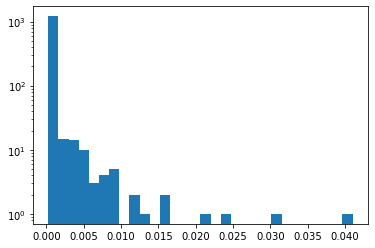

In [13]:
def ensemble_validation_errors(models, scalers, x, y,  docks):
    results = np.zeros(len(models))
    
    for i, m in enumerate(models):
        
        if scalers[i] != None:
            x_i = scalers[i].transform(x)
        
        results[i] = mean_absolute_error(m.predict(x_i),y)# * docks, y*docks)

    return results

print(scalers[0].feature_names_in_)
print(models[0].feature_importances_)

validation_errors = ensemble_validation_errors(models, scalers, val_set.iloc[:, :-1], val_set["bikes"], val_set_docks)

print(f'\nValidation error pre re-tuning:  {np.mean(validation_errors)}\n')

model_weights = model_weights / validation_errors**2
model_weights = model_weights / np.sum(model_weights)




plt.hist(model_weights, bins=30)
plt.yscale('log')
plt.show()


Error on second holdout station, with weights adjusted: 2.638297829468193



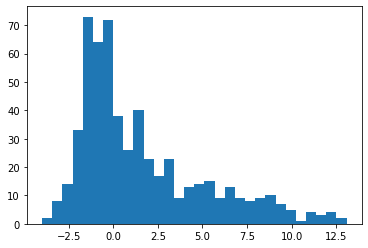

In [17]:
def ensemble_predict(models, scalers, model_weights, x):
    results = np.zeros(x.shape[0])

    for i, m in enumerate(models):
            
        if scalers[i] != None:
            x_i = scalers[i].transform(x)
        
        results = results + m.predict(x_i) * model_weights[i]

    return results

y_pred = ensemble_predict(models, scalers, model_weights, val_set_two.iloc[:,:-1]) #* val_set_docks_two

val_gold_two = val_set_two["bikes"].to_numpy()# * val_set_docks_two

print(f'\nError on second holdout station, with weights adjusted: {mean_absolute_error(val_gold_two, y_pred)}\n')

plt.hist(val_gold_two - y_pred, bins=30)
plt.show()


[2 2 4 ... 4 6 5]
    bikes
Id       
1       2
2       2
3       4
4       2
5       2
0       27
1       27
2       27
3       27
4       27
        ..
2245    15
2246    15
2247    15
2248    15
2249    15
Name: numDocks, Length: 2250, dtype: int64


(array([  4., 551., 615.,   0., 427., 396.,   0., 240.,  16.,   1.]),
 array([1. , 1.7, 2.4, 3.1, 3.8, 4.5, 5.2, 5.9, 6.6, 7.3, 8. ]),
 <BarContainer object of 10 artists>)

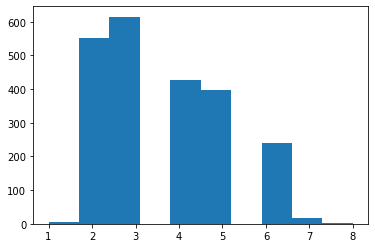

In [20]:
test = pd.read_csv('test.csv')

ids = test["Id"]

del test["Id"]


test, test_docks = vectorise_dataframe(test)


y_pred = np.around(ensemble_predict(models, scalers, model_weights, test)).astype(np.int32)

print(y_pred)

sub_df = pd.DataFrame(data=y_pred, index = ids, columns = ["bikes"])

sub_df.index.name = 'Id'

print(sub_df.head())

sub_df.to_csv("submission.csv")

print(test["numDocks"])

plt.hist(y_pred)